In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
import keras.backend.tensorflow_backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)
K.set_session(session)
K.get_session().run(tf.global_variables_initializer())


from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
from skimage.io import imread

%matplotlib inline

/home/bigdata/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(96, 96, 3)

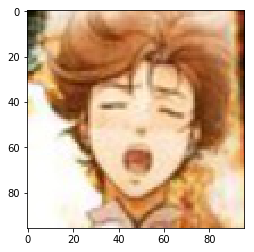

In [2]:
img = imread('AnimeDataset/faces/sub/121.jpg')
plt.imshow(img)
img.shape

In [15]:
IMG_SIZE = 64
G_IN_DIM = 100

g_in = Input((G_IN_DIM,))
g_x = Dense(128 * 8 * 8, activation="relu")(g_in)

g_x = Reshape((8, 8,128))(g_x)
g_x = UpSampling2D()(g_x)

g_x = Conv2D(128, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = UpSampling2D()(g_x)
g_x = Conv2D(64, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = UpSampling2D()(g_x)
g_x = Conv2D(32, kernel_size=4, padding="same")(g_x)
g_x = BatchNormalization(momentum=0.8)(g_x)
g_x = Activation("relu")(g_x)

g_x = Conv2D(3, kernel_size=4, padding="same")(g_x)
g_x = Activation("tanh")(g_x)

generator = Model(inputs=g_in, outputs=g_x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 128)       0         
__________

In [16]:
d_in = Input((IMG_SIZE, IMG_SIZE, 3))
d_x = Conv2D(16, kernel_size=3, strides=2, padding="same")(d_in)
d_x = LeakyReLU(alpha=0.2)(d_x)

d_x = Dropout(0.25)(d_x)
d_x = Conv2D(32, kernel_size=3, strides=2, padding="same")(d_x)
# d_x = ZeroPadding2D(padding=((0,1),(0,1)))(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)

d_x = Dropout(0.25)(d_x)
d_x = Conv2D(64, kernel_size=3, strides=2, padding="same")(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)
d_x = Dropout(0.25)(d_x)

d_x = Conv2D(128, kernel_size=3, strides=1, padding="same")(d_x)
d_x = BatchNormalization(momentum=0.8)(d_x)
d_x = LeakyReLU(alpha=0.2)(d_x)

d_x = Dropout(0.25)(d_x)
d_x = Flatten()(d_x)
d_x = Dense(1)(d_x)

critic = Model(d_in, d_x)
critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

In [17]:
# y_pos = -1, y_neg = 1


# For critic, the predicted labels are reversed
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

optimizer = RMSprop(lr=0.00005)
critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])


# For the combined model we will only train the generator
critic.trainable = False
g_valid = critic(g_x)
dg = Model(g_in, g_valid)
dg.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [18]:
dg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 128)       0         
__________

In [24]:
epochs = 100000
critic_repeat_times = 5
batch_size = 32
seed = 1
clip_value = 0.01

In [20]:
train_datagen = ImageDataGenerator(preprocessing_function=lambda x: (x / 127.5) -1)

train_generator = train_datagen.flow_from_directory(
        'AnimeDataset/faces/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode=None,
        seed=seed)

Found 33431 images belonging to 1 classes.


In [21]:
def generate_samples(save=False):

    zz = np.random.normal(0., 1., (100, G_IN_DIM))
    generated_images = generator.predict(zz)

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                IMG_SIZE * 10, IMG_SIZE, 3))
    img = np.hstack(rr)

#     if save:
#         plt.imsave(OUT_DIR + '/samples_%07d.png' % n, img, cmap=plt.cm.gray)
    return img

In [22]:
# write tensorboard summaries
sw = tf.summary.FileWriter('log/')

img_to_show = tf.placeholder(tf.float32, (IMG_SIZE * 10, IMG_SIZE * 10, 3))
image_op = tf.summary.image('samples', tf.expand_dims(img_to_show, axis=0))

def update_tb_summary(step, d_loss, g_loss, write_sample_images=True):

    s = tf.Summary()
    v = s.value.add()
    v.simple_value = d_loss
    v.tag = 'd_loss'
    
    v = s.value.add()
    v.simple_value = g_loss
    v.tag = 'g_loss'

    # generated image
    if write_sample_images:
        img = generate_samples(save=False)
        s.MergeFromString(session.run(image_op, feed_dict={img_to_show: img}))

    sw.add_summary(s, step)
    sw.flush()

In [26]:
real_label = -np.ones((batch_size, 1))
fake_label = np.ones_like(real_label)

for ep in range(epochs):
    if ep < 30000:
        continue
    for _ in range(critic_repeat_times):
        real_imgs = next(train_generator)
        while real_imgs.shape[0] != batch_size:
            real_imgs = next(train_generator)

        z = np.random.normal(0, 1, (batch_size, G_IN_DIM))

        fake_imgs = generator.predict(z)

        d_loss_real = critic.train_on_batch(real_imgs, real_label)
        d_loss_fake = critic.train_on_batch(fake_imgs, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Clip critic weights
        for l in critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)

    g_loss = dg.train_on_batch(z, real_label)

    # Plot the progress
    if ep % 10 == 0:
        print("%d [D loss: %f] [G loss: %f]" %
              (ep, 1 - d_loss[0], 1 - g_loss[0]))

    # If at save interval => save generated image samples
    if ep % 100 == 0:
        update_tb_summary(ep, 1 - d_loss[0], 1 - g_loss[0])

/home/bigdata/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


30000 [D loss: 0.999959] [G loss: 1.000056]
30010 [D loss: 0.999978] [G loss: 1.000063]
30020 [D loss: 0.999968] [G loss: 1.000070]
30030 [D loss: 0.999969] [G loss: 1.000065]
30040 [D loss: 0.999963] [G loss: 1.000060]
30050 [D loss: 0.999976] [G loss: 1.000051]
30060 [D loss: 0.999970] [G loss: 1.000027]
30070 [D loss: 0.999959] [G loss: 1.000034]
30080 [D loss: 0.999971] [G loss: 1.000063]
30090 [D loss: 0.999971] [G loss: 1.000063]
30100 [D loss: 0.999964] [G loss: 1.000053]
30110 [D loss: 0.999956] [G loss: 1.000074]
30120 [D loss: 0.999974] [G loss: 1.000066]
30130 [D loss: 0.999972] [G loss: 1.000044]
30140 [D loss: 0.999965] [G loss: 1.000045]
30150 [D loss: 0.999957] [G loss: 1.000062]
30160 [D loss: 0.999941] [G loss: 1.000067]
30170 [D loss: 0.999979] [G loss: 1.000051]
30180 [D loss: 0.999954] [G loss: 1.000070]
30190 [D loss: 0.999959] [G loss: 1.000062]
30200 [D loss: 0.999993] [G loss: 1.000084]
30210 [D loss: 0.999992] [G loss: 1.000048]
30220 [D loss: 0.999975] [G loss

31870 [D loss: 0.999969] [G loss: 1.000072]
31880 [D loss: 0.999991] [G loss: 1.000057]
31890 [D loss: 0.999967] [G loss: 1.000067]
31900 [D loss: 0.999961] [G loss: 1.000055]
31910 [D loss: 0.999963] [G loss: 1.000073]
31920 [D loss: 0.999952] [G loss: 1.000046]
31930 [D loss: 0.999962] [G loss: 1.000055]
31940 [D loss: 0.999963] [G loss: 1.000042]
31950 [D loss: 0.999957] [G loss: 1.000062]
31960 [D loss: 0.999967] [G loss: 1.000084]
31970 [D loss: 0.999972] [G loss: 1.000054]
31980 [D loss: 0.999970] [G loss: 1.000066]
31990 [D loss: 0.999969] [G loss: 1.000043]
32000 [D loss: 0.999981] [G loss: 1.000077]
32010 [D loss: 0.999962] [G loss: 1.000059]
32020 [D loss: 0.999972] [G loss: 1.000041]
32030 [D loss: 0.999970] [G loss: 1.000049]
32040 [D loss: 0.999960] [G loss: 1.000059]
32050 [D loss: 0.999961] [G loss: 1.000075]
32060 [D loss: 0.999967] [G loss: 1.000069]
32070 [D loss: 0.999976] [G loss: 1.000076]
32080 [D loss: 0.999960] [G loss: 1.000050]
32090 [D loss: 0.999955] [G loss

33740 [D loss: 0.999975] [G loss: 1.000073]
33750 [D loss: 0.999962] [G loss: 1.000050]
33760 [D loss: 0.999960] [G loss: 1.000050]
33770 [D loss: 0.999965] [G loss: 1.000061]
33780 [D loss: 0.999964] [G loss: 1.000073]
33790 [D loss: 0.999957] [G loss: 1.000064]
33800 [D loss: 0.999965] [G loss: 1.000059]
33810 [D loss: 0.999970] [G loss: 1.000045]
33820 [D loss: 0.999988] [G loss: 1.000055]
33830 [D loss: 0.999964] [G loss: 1.000085]
33840 [D loss: 0.999963] [G loss: 1.000040]
33850 [D loss: 0.999963] [G loss: 1.000055]
33860 [D loss: 0.999968] [G loss: 1.000066]
33870 [D loss: 0.999975] [G loss: 1.000046]
33880 [D loss: 0.999951] [G loss: 1.000046]
33890 [D loss: 0.999983] [G loss: 1.000054]
33900 [D loss: 0.999947] [G loss: 1.000052]
33910 [D loss: 0.999963] [G loss: 1.000066]
33920 [D loss: 0.999958] [G loss: 1.000062]
33930 [D loss: 0.999956] [G loss: 1.000063]
33940 [D loss: 0.999938] [G loss: 1.000039]
33950 [D loss: 0.999970] [G loss: 1.000063]
33960 [D loss: 0.999987] [G loss

35610 [D loss: 0.999960] [G loss: 1.000050]
35620 [D loss: 0.999974] [G loss: 1.000048]
35630 [D loss: 0.999974] [G loss: 1.000068]
35640 [D loss: 0.999970] [G loss: 1.000079]
35650 [D loss: 0.999959] [G loss: 1.000060]
35660 [D loss: 0.999974] [G loss: 1.000056]
35670 [D loss: 0.999957] [G loss: 1.000066]
35680 [D loss: 0.999962] [G loss: 1.000059]
35690 [D loss: 0.999973] [G loss: 1.000054]
35700 [D loss: 0.999971] [G loss: 1.000056]
35710 [D loss: 0.999966] [G loss: 1.000065]
35720 [D loss: 0.999963] [G loss: 1.000062]
35730 [D loss: 0.999964] [G loss: 1.000049]
35740 [D loss: 0.999954] [G loss: 1.000062]
35750 [D loss: 0.999957] [G loss: 1.000046]
35760 [D loss: 0.999970] [G loss: 1.000072]
35770 [D loss: 0.999968] [G loss: 1.000065]
35780 [D loss: 0.999967] [G loss: 1.000082]
35790 [D loss: 0.999962] [G loss: 1.000041]
35800 [D loss: 0.999983] [G loss: 1.000064]
35810 [D loss: 0.999976] [G loss: 1.000069]
35820 [D loss: 0.999963] [G loss: 1.000053]
35830 [D loss: 0.999977] [G loss

37480 [D loss: 0.999959] [G loss: 1.000077]
37490 [D loss: 0.999973] [G loss: 1.000048]
37500 [D loss: 0.999972] [G loss: 1.000070]
37510 [D loss: 0.999966] [G loss: 1.000050]
37520 [D loss: 0.999964] [G loss: 1.000064]
37530 [D loss: 0.999957] [G loss: 1.000048]
37540 [D loss: 0.999958] [G loss: 1.000061]
37550 [D loss: 0.999970] [G loss: 1.000060]
37560 [D loss: 0.999967] [G loss: 1.000056]
37570 [D loss: 0.999974] [G loss: 1.000063]
37580 [D loss: 0.999973] [G loss: 1.000046]
37590 [D loss: 0.999961] [G loss: 1.000060]
37600 [D loss: 0.999961] [G loss: 1.000065]
37610 [D loss: 0.999964] [G loss: 1.000060]
37620 [D loss: 0.999965] [G loss: 1.000060]
37630 [D loss: 0.999956] [G loss: 1.000049]
37640 [D loss: 0.999972] [G loss: 1.000063]
37650 [D loss: 0.999968] [G loss: 1.000055]
37660 [D loss: 0.999964] [G loss: 1.000050]
37670 [D loss: 0.999973] [G loss: 1.000055]
37680 [D loss: 0.999962] [G loss: 1.000065]
37690 [D loss: 0.999968] [G loss: 1.000051]
37700 [D loss: 0.999957] [G loss

39350 [D loss: 0.999966] [G loss: 1.000050]
39360 [D loss: 0.999960] [G loss: 1.000064]
39370 [D loss: 0.999962] [G loss: 1.000072]
39380 [D loss: 0.999967] [G loss: 1.000073]
39390 [D loss: 0.999976] [G loss: 1.000063]
39400 [D loss: 0.999973] [G loss: 1.000067]
39410 [D loss: 0.999963] [G loss: 1.000068]
39420 [D loss: 0.999952] [G loss: 1.000062]
39430 [D loss: 0.999978] [G loss: 1.000064]
39440 [D loss: 0.999963] [G loss: 1.000071]
39450 [D loss: 0.999973] [G loss: 1.000066]
39460 [D loss: 0.999953] [G loss: 1.000067]
39470 [D loss: 0.999978] [G loss: 1.000076]
39480 [D loss: 0.999960] [G loss: 1.000090]
39490 [D loss: 0.999968] [G loss: 1.000064]
39500 [D loss: 0.999966] [G loss: 1.000061]
39510 [D loss: 0.999961] [G loss: 1.000040]
39520 [D loss: 0.999973] [G loss: 1.000050]
39530 [D loss: 0.999964] [G loss: 1.000076]
39540 [D loss: 0.999950] [G loss: 1.000078]
39550 [D loss: 0.999963] [G loss: 1.000064]
39560 [D loss: 0.999958] [G loss: 1.000061]
39570 [D loss: 0.999953] [G loss

41220 [D loss: 0.999965] [G loss: 1.000070]
41230 [D loss: 0.999967] [G loss: 1.000068]
41240 [D loss: 0.999969] [G loss: 1.000072]
41250 [D loss: 0.999961] [G loss: 1.000069]
41260 [D loss: 0.999961] [G loss: 1.000079]
41270 [D loss: 0.999961] [G loss: 1.000061]
41280 [D loss: 0.999966] [G loss: 1.000055]
41290 [D loss: 0.999963] [G loss: 1.000075]
41300 [D loss: 0.999963] [G loss: 1.000070]
41310 [D loss: 0.999960] [G loss: 1.000069]
41320 [D loss: 0.999974] [G loss: 1.000056]
41330 [D loss: 0.999957] [G loss: 1.000052]
41340 [D loss: 0.999961] [G loss: 1.000058]
41350 [D loss: 0.999961] [G loss: 1.000053]
41360 [D loss: 0.999965] [G loss: 1.000062]
41370 [D loss: 0.999960] [G loss: 1.000059]
41380 [D loss: 0.999968] [G loss: 1.000065]
41390 [D loss: 0.999972] [G loss: 1.000057]
41400 [D loss: 0.999966] [G loss: 1.000061]
41410 [D loss: 0.999963] [G loss: 1.000060]
41420 [D loss: 0.999969] [G loss: 1.000054]
41430 [D loss: 0.999966] [G loss: 1.000057]
41440 [D loss: 0.999963] [G loss

43090 [D loss: 0.999961] [G loss: 1.000066]
43100 [D loss: 0.999967] [G loss: 1.000061]
43110 [D loss: 0.999972] [G loss: 1.000068]
43120 [D loss: 0.999969] [G loss: 1.000054]
43130 [D loss: 0.999971] [G loss: 1.000058]
43140 [D loss: 0.999972] [G loss: 1.000067]
43150 [D loss: 0.999962] [G loss: 1.000061]
43160 [D loss: 0.999965] [G loss: 1.000065]
43170 [D loss: 0.999968] [G loss: 1.000068]
43180 [D loss: 0.999967] [G loss: 1.000062]
43190 [D loss: 0.999964] [G loss: 1.000054]
43200 [D loss: 0.999961] [G loss: 1.000062]
43210 [D loss: 0.999970] [G loss: 1.000060]
43220 [D loss: 0.999970] [G loss: 1.000062]
43230 [D loss: 0.999970] [G loss: 1.000056]
43240 [D loss: 0.999966] [G loss: 1.000066]
43250 [D loss: 0.999966] [G loss: 1.000063]
43260 [D loss: 0.999959] [G loss: 1.000060]
43270 [D loss: 0.999963] [G loss: 1.000066]
43280 [D loss: 0.999964] [G loss: 1.000062]
43290 [D loss: 0.999974] [G loss: 1.000053]
43300 [D loss: 0.999967] [G loss: 1.000062]
43310 [D loss: 0.999971] [G loss

44960 [D loss: 0.999952] [G loss: 1.000071]
44970 [D loss: 0.999976] [G loss: 1.000070]
44980 [D loss: 0.999965] [G loss: 1.000052]
44990 [D loss: 0.999973] [G loss: 1.000079]
45000 [D loss: 0.999977] [G loss: 1.000071]
45010 [D loss: 0.999965] [G loss: 1.000059]
45020 [D loss: 0.999958] [G loss: 1.000070]
45030 [D loss: 0.999959] [G loss: 1.000059]
45040 [D loss: 0.999964] [G loss: 1.000063]
45050 [D loss: 0.999968] [G loss: 1.000053]
45060 [D loss: 0.999976] [G loss: 1.000061]
45070 [D loss: 0.999965] [G loss: 1.000049]
45080 [D loss: 0.999967] [G loss: 1.000050]
45090 [D loss: 0.999959] [G loss: 1.000065]
45100 [D loss: 0.999963] [G loss: 1.000054]
45110 [D loss: 0.999959] [G loss: 1.000076]
45120 [D loss: 0.999956] [G loss: 1.000061]
45130 [D loss: 0.999966] [G loss: 1.000075]
45140 [D loss: 0.999963] [G loss: 1.000054]
45150 [D loss: 0.999969] [G loss: 1.000052]
45160 [D loss: 0.999973] [G loss: 1.000052]
45170 [D loss: 0.999965] [G loss: 1.000069]
45180 [D loss: 0.999967] [G loss

46830 [D loss: 0.999981] [G loss: 1.000019]
46840 [D loss: 0.999975] [G loss: 1.000065]
46850 [D loss: 0.999971] [G loss: 1.000074]
46860 [D loss: 0.999967] [G loss: 1.000044]
46870 [D loss: 0.999968] [G loss: 1.000066]
46880 [D loss: 0.999973] [G loss: 1.000050]
46890 [D loss: 0.999960] [G loss: 1.000058]
46900 [D loss: 0.999956] [G loss: 1.000057]
46910 [D loss: 0.999961] [G loss: 1.000072]
46920 [D loss: 0.999967] [G loss: 1.000089]
46930 [D loss: 0.999981] [G loss: 1.000076]
46940 [D loss: 0.999972] [G loss: 1.000044]
46950 [D loss: 0.999982] [G loss: 1.000038]
46960 [D loss: 0.999972] [G loss: 1.000037]
46970 [D loss: 0.999975] [G loss: 1.000055]
46980 [D loss: 0.999954] [G loss: 1.000083]
46990 [D loss: 0.999977] [G loss: 1.000046]
47000 [D loss: 0.999974] [G loss: 1.000056]
47010 [D loss: 0.999978] [G loss: 1.000015]
47020 [D loss: 0.999964] [G loss: 1.000057]
47030 [D loss: 0.999957] [G loss: 1.000091]
47040 [D loss: 0.999969] [G loss: 1.000106]
47050 [D loss: 0.999975] [G loss

48700 [D loss: 0.999972] [G loss: 1.000062]
48710 [D loss: 0.999966] [G loss: 1.000045]
48720 [D loss: 0.999965] [G loss: 1.000064]
48730 [D loss: 0.999968] [G loss: 1.000057]
48740 [D loss: 0.999969] [G loss: 1.000069]
48750 [D loss: 0.999976] [G loss: 1.000055]
48760 [D loss: 0.999960] [G loss: 1.000063]
48770 [D loss: 0.999973] [G loss: 1.000048]
48780 [D loss: 0.999961] [G loss: 1.000071]
48790 [D loss: 0.999966] [G loss: 1.000079]
48800 [D loss: 0.999959] [G loss: 1.000050]
48810 [D loss: 0.999957] [G loss: 1.000069]
48820 [D loss: 0.999958] [G loss: 1.000074]
48830 [D loss: 0.999969] [G loss: 1.000050]
48840 [D loss: 0.999969] [G loss: 1.000076]
48850 [D loss: 0.999973] [G loss: 1.000067]
48860 [D loss: 0.999971] [G loss: 1.000057]
48870 [D loss: 0.999962] [G loss: 1.000069]
48880 [D loss: 0.999977] [G loss: 1.000052]
48890 [D loss: 0.999973] [G loss: 1.000057]
48900 [D loss: 0.999967] [G loss: 1.000082]
48910 [D loss: 0.999978] [G loss: 1.000067]
48920 [D loss: 0.999967] [G loss

50570 [D loss: 0.999988] [G loss: 1.000045]
50580 [D loss: 0.999965] [G loss: 1.000046]
50590 [D loss: 0.999967] [G loss: 1.000087]
50600 [D loss: 0.999972] [G loss: 1.000052]
50610 [D loss: 0.999961] [G loss: 1.000061]
50620 [D loss: 0.999963] [G loss: 1.000063]
50630 [D loss: 0.999991] [G loss: 1.000069]
50640 [D loss: 0.999971] [G loss: 1.000019]
50650 [D loss: 0.999959] [G loss: 1.000063]
50660 [D loss: 0.999971] [G loss: 1.000056]
50670 [D loss: 0.999971] [G loss: 1.000036]
50680 [D loss: 0.999967] [G loss: 1.000075]
50690 [D loss: 0.999957] [G loss: 1.000055]
50700 [D loss: 0.999977] [G loss: 1.000080]
50710 [D loss: 0.999965] [G loss: 1.000045]
50720 [D loss: 0.999956] [G loss: 1.000055]
50730 [D loss: 0.999957] [G loss: 1.000054]
50740 [D loss: 0.999996] [G loss: 1.000023]
50750 [D loss: 0.999973] [G loss: 1.000060]
50760 [D loss: 0.999957] [G loss: 1.000076]
50770 [D loss: 0.999971] [G loss: 1.000087]
50780 [D loss: 0.999999] [G loss: 1.000040]
50790 [D loss: 0.999971] [G loss

52440 [D loss: 0.999951] [G loss: 1.000058]
52450 [D loss: 0.999948] [G loss: 1.000051]
52460 [D loss: 0.999985] [G loss: 1.000071]
52470 [D loss: 0.999949] [G loss: 1.000041]
52480 [D loss: 0.999968] [G loss: 1.000086]
52490 [D loss: 0.999961] [G loss: 1.000037]
52500 [D loss: 0.999955] [G loss: 1.000027]
52510 [D loss: 0.999959] [G loss: 1.000069]
52520 [D loss: 0.999950] [G loss: 1.000098]
52530 [D loss: 0.999975] [G loss: 1.000048]
52540 [D loss: 0.999967] [G loss: 1.000085]
52550 [D loss: 0.999919] [G loss: 1.000071]
52560 [D loss: 1.000012] [G loss: 1.000096]
52570 [D loss: 0.999969] [G loss: 1.000087]
52580 [D loss: 0.999967] [G loss: 1.000074]
52590 [D loss: 0.999954] [G loss: 1.000069]
52600 [D loss: 0.999961] [G loss: 1.000073]
52610 [D loss: 0.999952] [G loss: 1.000122]
52620 [D loss: 0.999966] [G loss: 1.000073]
52630 [D loss: 0.999969] [G loss: 1.000072]
52640 [D loss: 0.999969] [G loss: 1.000055]
52650 [D loss: 0.999966] [G loss: 1.000059]
52660 [D loss: 0.999959] [G loss

54310 [D loss: 0.999974] [G loss: 1.000072]
54320 [D loss: 0.999975] [G loss: 1.000055]
54330 [D loss: 0.999975] [G loss: 1.000066]
54340 [D loss: 0.999966] [G loss: 1.000066]
54350 [D loss: 0.999972] [G loss: 1.000052]
54360 [D loss: 0.999961] [G loss: 1.000058]
54370 [D loss: 0.999968] [G loss: 1.000083]
54380 [D loss: 0.999959] [G loss: 1.000069]
54390 [D loss: 0.999975] [G loss: 1.000082]
54400 [D loss: 0.999949] [G loss: 1.000064]
54410 [D loss: 0.999967] [G loss: 1.000071]
54420 [D loss: 0.999982] [G loss: 1.000048]
54430 [D loss: 0.999956] [G loss: 1.000065]
54440 [D loss: 0.999978] [G loss: 1.000070]
54450 [D loss: 0.999983] [G loss: 1.000084]
54460 [D loss: 0.999970] [G loss: 1.000019]
54470 [D loss: 0.999956] [G loss: 1.000074]
54480 [D loss: 0.999983] [G loss: 1.000067]
54490 [D loss: 0.999996] [G loss: 1.000047]
54500 [D loss: 0.999973] [G loss: 1.000039]
54510 [D loss: 0.999977] [G loss: 1.000077]
54520 [D loss: 0.999982] [G loss: 1.000032]
54530 [D loss: 0.999968] [G loss

56180 [D loss: 0.999948] [G loss: 1.000090]
56190 [D loss: 0.999940] [G loss: 1.000041]
56200 [D loss: 0.999985] [G loss: 1.000015]
56210 [D loss: 0.999965] [G loss: 1.000102]
56220 [D loss: 0.999951] [G loss: 1.000113]
56230 [D loss: 1.000002] [G loss: 1.000006]
56240 [D loss: 0.999957] [G loss: 1.000040]
56250 [D loss: 0.999967] [G loss: 1.000069]
56260 [D loss: 0.999946] [G loss: 1.000051]
56270 [D loss: 0.999971] [G loss: 1.000057]
56280 [D loss: 0.999958] [G loss: 1.000074]
56290 [D loss: 0.999961] [G loss: 1.000094]
56300 [D loss: 0.999943] [G loss: 1.000121]
56310 [D loss: 0.999998] [G loss: 1.000025]
56320 [D loss: 0.999963] [G loss: 1.000052]
56330 [D loss: 0.999959] [G loss: 1.000122]
56340 [D loss: 0.999977] [G loss: 0.999980]
56350 [D loss: 0.999973] [G loss: 1.000049]
56360 [D loss: 0.999948] [G loss: 1.000091]
56370 [D loss: 0.999941] [G loss: 1.000059]
56380 [D loss: 0.999958] [G loss: 1.000033]
56390 [D loss: 0.999960] [G loss: 1.000088]
56400 [D loss: 1.000035] [G loss

58050 [D loss: 0.999987] [G loss: 1.000011]
58060 [D loss: 0.999976] [G loss: 1.000139]
58070 [D loss: 1.000026] [G loss: 0.999850]
58080 [D loss: 0.999985] [G loss: 1.000065]
58090 [D loss: 0.999873] [G loss: 1.000197]
58100 [D loss: 0.999968] [G loss: 1.000040]
58110 [D loss: 0.999924] [G loss: 1.000180]
58120 [D loss: 1.000031] [G loss: 0.999883]
58130 [D loss: 0.999933] [G loss: 1.000101]
58140 [D loss: 1.000042] [G loss: 1.000077]
58150 [D loss: 0.999951] [G loss: 1.000090]
58160 [D loss: 1.000076] [G loss: 1.000247]
58170 [D loss: 0.999958] [G loss: 1.000043]
58180 [D loss: 0.999956] [G loss: 1.000323]
58190 [D loss: 0.999977] [G loss: 1.000018]
58200 [D loss: 0.999924] [G loss: 1.000288]
58210 [D loss: 1.000109] [G loss: 0.999650]
58220 [D loss: 0.999957] [G loss: 1.000125]
58230 [D loss: 1.000148] [G loss: 0.999721]
58240 [D loss: 0.999963] [G loss: 1.000117]
58250 [D loss: 1.000154] [G loss: 1.000028]
58260 [D loss: 0.999963] [G loss: 1.000079]
58270 [D loss: 1.000044] [G loss

59920 [D loss: 1.000094] [G loss: 1.000137]
59930 [D loss: 0.999951] [G loss: 1.000066]
59940 [D loss: 0.999844] [G loss: 1.000225]
59950 [D loss: 1.000151] [G loss: 0.999800]
59960 [D loss: 0.999940] [G loss: 1.000115]
59970 [D loss: 1.000130] [G loss: 1.000028]
59980 [D loss: 0.999981] [G loss: 1.000078]
59990 [D loss: 0.999912] [G loss: 1.000194]
60000 [D loss: 1.000028] [G loss: 0.999891]
60010 [D loss: 0.999945] [G loss: 1.000101]
60020 [D loss: 0.999861] [G loss: 1.000194]
60030 [D loss: 0.999998] [G loss: 1.000054]
60040 [D loss: 0.999943] [G loss: 1.000122]
60050 [D loss: 0.999961] [G loss: 1.000235]
60060 [D loss: 0.999973] [G loss: 0.999977]
60070 [D loss: 0.999941] [G loss: 1.000132]
60080 [D loss: 1.000090] [G loss: 1.000000]
60090 [D loss: 0.999936] [G loss: 1.000044]
60100 [D loss: 0.999935] [G loss: 1.000152]
60110 [D loss: 1.000138] [G loss: 0.999969]
60120 [D loss: 0.999965] [G loss: 1.000123]
60130 [D loss: 0.999933] [G loss: 1.000203]
60140 [D loss: 0.999973] [G loss

61790 [D loss: 0.999970] [G loss: 1.000063]
61800 [D loss: 0.999938] [G loss: 1.000128]
61810 [D loss: 0.999973] [G loss: 0.999974]
61820 [D loss: 0.999994] [G loss: 1.000098]
61830 [D loss: 1.000059] [G loss: 1.000076]
61840 [D loss: 0.999927] [G loss: 1.000126]
61850 [D loss: 0.999977] [G loss: 1.000031]
61860 [D loss: 0.999902] [G loss: 1.000269]
61870 [D loss: 0.999978] [G loss: 1.000067]
61880 [D loss: 0.999983] [G loss: 1.000182]
61890 [D loss: 1.000044] [G loss: 1.000255]
61900 [D loss: 0.999956] [G loss: 1.000078]
61910 [D loss: 0.999987] [G loss: 0.999792]
61920 [D loss: 0.999980] [G loss: 1.000136]
61930 [D loss: 1.000012] [G loss: 1.000113]
61940 [D loss: 1.000012] [G loss: 1.000022]
61950 [D loss: 0.999965] [G loss: 1.000051]
61960 [D loss: 0.999967] [G loss: 1.000054]
61970 [D loss: 1.000043] [G loss: 0.999973]
61980 [D loss: 0.999907] [G loss: 1.000051]
61990 [D loss: 0.999984] [G loss: 0.999992]
62000 [D loss: 0.999965] [G loss: 0.999989]
62010 [D loss: 0.999999] [G loss

63660 [D loss: 0.999998] [G loss: 1.000242]
63670 [D loss: 1.000008] [G loss: 1.000066]
63680 [D loss: 0.999976] [G loss: 1.000046]
63690 [D loss: 0.999961] [G loss: 1.000032]
63700 [D loss: 0.999938] [G loss: 1.000018]
63710 [D loss: 0.999985] [G loss: 1.000191]
63720 [D loss: 1.000148] [G loss: 0.999858]
63730 [D loss: 0.999905] [G loss: 1.000187]
63740 [D loss: 1.000130] [G loss: 1.000088]
63750 [D loss: 0.999946] [G loss: 1.000090]
63760 [D loss: 0.999903] [G loss: 1.000200]
63770 [D loss: 0.999956] [G loss: 1.000100]
63780 [D loss: 1.000032] [G loss: 0.999820]
63790 [D loss: 1.000092] [G loss: 1.000031]
63800 [D loss: 0.999912] [G loss: 1.000088]
63810 [D loss: 0.999921] [G loss: 1.000124]
63820 [D loss: 0.999887] [G loss: 1.000128]
63830 [D loss: 0.999955] [G loss: 0.999841]
63840 [D loss: 0.999902] [G loss: 1.000165]
63850 [D loss: 0.999884] [G loss: 0.999889]
63860 [D loss: 0.999981] [G loss: 0.999991]
63870 [D loss: 0.999951] [G loss: 1.000107]
63880 [D loss: 1.000070] [G loss

65530 [D loss: 1.000011] [G loss: 0.999936]
65540 [D loss: 0.999972] [G loss: 1.000046]
65550 [D loss: 0.999934] [G loss: 1.000181]
65560 [D loss: 1.000002] [G loss: 1.000021]
65570 [D loss: 0.999936] [G loss: 1.000057]
65580 [D loss: 0.999954] [G loss: 1.000039]
65590 [D loss: 1.000045] [G loss: 0.999948]
65600 [D loss: 0.999948] [G loss: 1.000135]
65610 [D loss: 0.999964] [G loss: 1.000043]
65620 [D loss: 0.999954] [G loss: 0.999931]
65630 [D loss: 0.999940] [G loss: 1.000097]
65640 [D loss: 1.000028] [G loss: 1.000103]
65650 [D loss: 1.000035] [G loss: 1.000049]
65660 [D loss: 0.999982] [G loss: 1.000107]
65670 [D loss: 0.999956] [G loss: 1.000091]
65680 [D loss: 0.999914] [G loss: 1.000006]
65690 [D loss: 0.999969] [G loss: 1.000180]
65700 [D loss: 1.000022] [G loss: 0.999837]
65710 [D loss: 0.999980] [G loss: 1.000120]
65720 [D loss: 0.999943] [G loss: 1.000099]
65730 [D loss: 1.000137] [G loss: 0.999974]
65740 [D loss: 0.999928] [G loss: 0.999946]
65750 [D loss: 0.999961] [G loss

67400 [D loss: 0.999929] [G loss: 1.000035]
67410 [D loss: 0.999975] [G loss: 1.000118]
67420 [D loss: 0.999948] [G loss: 1.000307]
67430 [D loss: 0.999949] [G loss: 1.000075]
67440 [D loss: 0.999923] [G loss: 1.000095]
67450 [D loss: 0.999999] [G loss: 1.000135]
67460 [D loss: 1.000068] [G loss: 0.999935]
67470 [D loss: 0.999972] [G loss: 1.000106]
67480 [D loss: 0.999895] [G loss: 1.000177]
67490 [D loss: 1.000001] [G loss: 0.999907]
67500 [D loss: 0.999952] [G loss: 1.000046]
67510 [D loss: 0.999971] [G loss: 1.000124]
67520 [D loss: 1.000021] [G loss: 1.000129]
67530 [D loss: 1.000099] [G loss: 1.000036]
67540 [D loss: 0.999962] [G loss: 1.000111]
67550 [D loss: 0.999960] [G loss: 1.000195]
67560 [D loss: 0.999997] [G loss: 1.000059]
67570 [D loss: 0.999996] [G loss: 1.000021]
67580 [D loss: 0.999938] [G loss: 1.000092]
67590 [D loss: 1.000039] [G loss: 1.000138]
67600 [D loss: 1.000013] [G loss: 0.999948]
67610 [D loss: 0.999890] [G loss: 1.000186]
67620 [D loss: 1.000206] [G loss

69270 [D loss: 0.999926] [G loss: 1.000260]
69280 [D loss: 1.000175] [G loss: 0.999896]
69290 [D loss: 0.999943] [G loss: 1.000134]
69300 [D loss: 0.999999] [G loss: 1.000258]
69310 [D loss: 0.999960] [G loss: 0.999946]
69320 [D loss: 0.999967] [G loss: 1.000066]
69330 [D loss: 0.999928] [G loss: 1.000115]
69340 [D loss: 1.000070] [G loss: 1.000136]
69350 [D loss: 1.000048] [G loss: 0.999822]
69360 [D loss: 1.000013] [G loss: 1.000000]
69370 [D loss: 0.999984] [G loss: 1.000141]
69380 [D loss: 0.999953] [G loss: 1.000184]
69390 [D loss: 0.999966] [G loss: 1.000121]
69400 [D loss: 0.999900] [G loss: 0.999981]
69410 [D loss: 1.000038] [G loss: 0.999982]
69420 [D loss: 0.999975] [G loss: 1.000199]
69430 [D loss: 1.000080] [G loss: 0.999976]
69440 [D loss: 1.000014] [G loss: 0.999866]
69450 [D loss: 0.999990] [G loss: 1.000118]
69460 [D loss: 1.000043] [G loss: 1.000033]
69470 [D loss: 0.999906] [G loss: 0.999973]
69480 [D loss: 0.999965] [G loss: 1.000135]
69490 [D loss: 1.000009] [G loss

71140 [D loss: 0.999957] [G loss: 1.000514]
71150 [D loss: 1.000626] [G loss: 0.999679]
71160 [D loss: 0.999830] [G loss: 1.000548]
71170 [D loss: 1.000555] [G loss: 0.999199]
71180 [D loss: 0.999863] [G loss: 1.000351]
71190 [D loss: 1.000264] [G loss: 1.000938]
71200 [D loss: 0.999907] [G loss: 1.000300]
71210 [D loss: 1.000416] [G loss: 0.999812]
71220 [D loss: 0.999926] [G loss: 1.000159]
71230 [D loss: 1.000083] [G loss: 1.001306]
71240 [D loss: 0.999968] [G loss: 1.000117]
71250 [D loss: 1.000065] [G loss: 1.001315]
71260 [D loss: 1.000018] [G loss: 0.999931]
71270 [D loss: 0.999731] [G loss: 1.001940]
71280 [D loss: 0.999942] [G loss: 1.000146]
71290 [D loss: 1.000401] [G loss: 1.000702]
71300 [D loss: 0.999996] [G loss: 1.000018]
71310 [D loss: 0.999679] [G loss: 1.002158]
71320 [D loss: 0.999970] [G loss: 1.000094]
71330 [D loss: 0.999646] [G loss: 1.001454]
71340 [D loss: 0.999944] [G loss: 1.000103]
71350 [D loss: 0.999859] [G loss: 1.002753]
71360 [D loss: 0.999984] [G loss

73010 [D loss: 0.999936] [G loss: 1.000235]
73020 [D loss: 1.000043] [G loss: 0.999777]
73030 [D loss: 0.999907] [G loss: 1.000106]
73040 [D loss: 1.000110] [G loss: 1.000174]
73050 [D loss: 0.999989] [G loss: 1.000004]
73060 [D loss: 0.999942] [G loss: 1.000133]
73070 [D loss: 1.000228] [G loss: 1.000087]
73080 [D loss: 0.999946] [G loss: 1.000155]
73090 [D loss: 0.999992] [G loss: 0.999941]
73100 [D loss: 0.999932] [G loss: 1.000134]
73110 [D loss: 0.999887] [G loss: 1.000181]
73120 [D loss: 0.999975] [G loss: 1.000121]
73130 [D loss: 0.999866] [G loss: 1.000297]
73140 [D loss: 0.999949] [G loss: 1.000072]
73150 [D loss: 1.000066] [G loss: 1.000153]
73160 [D loss: 0.999941] [G loss: 1.000136]
73170 [D loss: 1.000101] [G loss: 0.999732]
73180 [D loss: 0.999956] [G loss: 1.000048]
73190 [D loss: 1.000054] [G loss: 1.000517]
73200 [D loss: 1.000089] [G loss: 0.999861]
73210 [D loss: 0.999865] [G loss: 1.000196]
73220 [D loss: 1.000036] [G loss: 0.999788]
73230 [D loss: 0.999964] [G loss

74880 [D loss: 0.999958] [G loss: 1.000060]
74890 [D loss: 0.999961] [G loss: 1.000087]
74900 [D loss: 0.999965] [G loss: 1.000050]
74910 [D loss: 0.999968] [G loss: 1.000053]
74920 [D loss: 0.999962] [G loss: 1.000053]
74930 [D loss: 0.999963] [G loss: 1.000054]
74940 [D loss: 0.999959] [G loss: 1.000065]
74950 [D loss: 0.999965] [G loss: 1.000058]
74960 [D loss: 0.999967] [G loss: 1.000044]
74970 [D loss: 0.999970] [G loss: 1.000054]
74980 [D loss: 0.999952] [G loss: 1.000049]
74990 [D loss: 0.999962] [G loss: 1.000060]
75000 [D loss: 0.999966] [G loss: 1.000058]
75010 [D loss: 0.999968] [G loss: 1.000053]
75020 [D loss: 0.999962] [G loss: 1.000056]
75030 [D loss: 0.999964] [G loss: 1.000057]
75040 [D loss: 0.999969] [G loss: 1.000051]
75050 [D loss: 0.999969] [G loss: 1.000055]
75060 [D loss: 0.999968] [G loss: 1.000062]
75070 [D loss: 0.999964] [G loss: 1.000058]
75080 [D loss: 0.999966] [G loss: 1.000063]
75090 [D loss: 0.999966] [G loss: 1.000059]
75100 [D loss: 0.999967] [G loss

76750 [D loss: 0.999963] [G loss: 1.000044]
76760 [D loss: 0.999960] [G loss: 1.000069]
76770 [D loss: 0.999962] [G loss: 1.000075]
76780 [D loss: 0.999972] [G loss: 1.000049]
76790 [D loss: 0.999962] [G loss: 1.000056]
76800 [D loss: 0.999981] [G loss: 1.000073]
76810 [D loss: 0.999974] [G loss: 1.000059]
76820 [D loss: 0.999974] [G loss: 1.000075]
76830 [D loss: 0.999972] [G loss: 1.000059]
76840 [D loss: 0.999962] [G loss: 1.000059]
76850 [D loss: 0.999970] [G loss: 1.000067]
76860 [D loss: 0.999970] [G loss: 1.000055]
76870 [D loss: 0.999985] [G loss: 1.000071]
76880 [D loss: 0.999965] [G loss: 1.000060]
76890 [D loss: 0.999966] [G loss: 1.000061]
76900 [D loss: 0.999974] [G loss: 1.000062]
76910 [D loss: 0.999962] [G loss: 1.000051]
76920 [D loss: 0.999970] [G loss: 1.000062]
76930 [D loss: 0.999970] [G loss: 1.000064]
76940 [D loss: 0.999974] [G loss: 1.000042]
76950 [D loss: 0.999965] [G loss: 1.000079]
76960 [D loss: 0.999958] [G loss: 1.000069]
76970 [D loss: 0.999967] [G loss

78620 [D loss: 0.999978] [G loss: 1.000109]
78630 [D loss: 0.999977] [G loss: 1.000068]
78640 [D loss: 0.999974] [G loss: 1.000064]
78650 [D loss: 0.999914] [G loss: 1.000066]
78660 [D loss: 0.999976] [G loss: 1.000095]
78670 [D loss: 0.999974] [G loss: 1.000107]
78680 [D loss: 0.999980] [G loss: 1.000019]
78690 [D loss: 0.999972] [G loss: 1.000052]
78700 [D loss: 0.999969] [G loss: 1.000058]
78710 [D loss: 0.999953] [G loss: 1.000082]
78720 [D loss: 0.999974] [G loss: 1.000051]
78730 [D loss: 0.999948] [G loss: 1.000078]
78740 [D loss: 0.999966] [G loss: 1.000067]
78750 [D loss: 0.999983] [G loss: 1.000034]
78760 [D loss: 0.999951] [G loss: 1.000093]
78770 [D loss: 0.999983] [G loss: 1.000070]
78780 [D loss: 0.999955] [G loss: 1.000071]
78790 [D loss: 0.999958] [G loss: 1.000076]
78800 [D loss: 0.999995] [G loss: 1.000038]
78810 [D loss: 0.999963] [G loss: 1.000081]
78820 [D loss: 0.999952] [G loss: 1.000047]
78830 [D loss: 0.999959] [G loss: 1.000083]
78840 [D loss: 0.999966] [G loss

80490 [D loss: 0.999959] [G loss: 1.000085]
80500 [D loss: 0.999943] [G loss: 1.000085]
80510 [D loss: 1.000011] [G loss: 1.000026]
80520 [D loss: 0.999956] [G loss: 1.000035]
80530 [D loss: 0.999952] [G loss: 1.000089]
80540 [D loss: 0.999948] [G loss: 1.000073]
80550 [D loss: 0.999984] [G loss: 1.000010]
80560 [D loss: 0.999958] [G loss: 1.000062]
80570 [D loss: 0.999956] [G loss: 1.000088]
80580 [D loss: 0.999986] [G loss: 1.000056]
80590 [D loss: 0.999951] [G loss: 1.000068]
80600 [D loss: 0.999962] [G loss: 1.000043]
80610 [D loss: 0.999961] [G loss: 1.000059]
80620 [D loss: 0.999977] [G loss: 1.000038]
80630 [D loss: 0.999973] [G loss: 1.000073]
80640 [D loss: 0.999965] [G loss: 1.000073]
80650 [D loss: 0.999959] [G loss: 1.000060]
80660 [D loss: 0.999961] [G loss: 1.000066]
80670 [D loss: 0.999959] [G loss: 1.000094]
80680 [D loss: 0.999960] [G loss: 1.000060]
80690 [D loss: 0.999961] [G loss: 1.000091]
80700 [D loss: 0.999981] [G loss: 1.000085]
80710 [D loss: 0.999976] [G loss

82360 [D loss: 0.999950] [G loss: 1.000083]
82370 [D loss: 0.999942] [G loss: 1.000079]
82380 [D loss: 0.999951] [G loss: 1.000048]
82390 [D loss: 0.999965] [G loss: 1.000063]
82400 [D loss: 0.999970] [G loss: 1.000046]
82410 [D loss: 1.000000] [G loss: 1.000061]
82420 [D loss: 0.999967] [G loss: 1.000050]
82430 [D loss: 0.999980] [G loss: 1.000042]
82440 [D loss: 0.999974] [G loss: 1.000037]
82450 [D loss: 0.999961] [G loss: 1.000078]
82460 [D loss: 0.999975] [G loss: 1.000058]
82470 [D loss: 0.999967] [G loss: 1.000060]
82480 [D loss: 0.999956] [G loss: 1.000037]
82490 [D loss: 0.999975] [G loss: 1.000096]
82500 [D loss: 0.999990] [G loss: 1.000066]
82510 [D loss: 0.999951] [G loss: 1.000070]
82520 [D loss: 0.999949] [G loss: 1.000062]
82530 [D loss: 0.999999] [G loss: 1.000026]
82540 [D loss: 0.999952] [G loss: 1.000071]
82550 [D loss: 0.999962] [G loss: 1.000089]
82560 [D loss: 0.999984] [G loss: 1.000043]
82570 [D loss: 0.999971] [G loss: 1.000053]
82580 [D loss: 0.999963] [G loss

84230 [D loss: 0.999956] [G loss: 1.000104]
84240 [D loss: 0.999970] [G loss: 1.000113]
84250 [D loss: 0.999969] [G loss: 1.000035]
84260 [D loss: 0.999943] [G loss: 1.000039]
84270 [D loss: 0.999966] [G loss: 1.000100]
84280 [D loss: 0.999962] [G loss: 1.000090]
84290 [D loss: 0.999968] [G loss: 1.000067]
84300 [D loss: 0.999994] [G loss: 1.000048]
84310 [D loss: 0.999968] [G loss: 1.000069]
84320 [D loss: 0.999939] [G loss: 1.000020]
84330 [D loss: 0.999998] [G loss: 1.000104]
84340 [D loss: 0.999966] [G loss: 1.000063]
84350 [D loss: 0.999978] [G loss: 1.000052]
84360 [D loss: 0.999933] [G loss: 1.000079]
84370 [D loss: 0.999990] [G loss: 0.999983]
84380 [D loss: 0.999953] [G loss: 1.000074]
84390 [D loss: 0.999964] [G loss: 1.000078]
84400 [D loss: 0.999924] [G loss: 1.000150]
84410 [D loss: 0.999991] [G loss: 1.000099]
84420 [D loss: 0.999972] [G loss: 1.000093]
84430 [D loss: 0.999934] [G loss: 1.000131]
84440 [D loss: 0.999989] [G loss: 1.000121]
84450 [D loss: 0.999974] [G loss

86100 [D loss: 0.999960] [G loss: 1.000050]
86110 [D loss: 0.999982] [G loss: 1.000083]
86120 [D loss: 0.999973] [G loss: 1.000067]
86130 [D loss: 0.999954] [G loss: 1.000068]
86140 [D loss: 0.999961] [G loss: 1.000047]
86150 [D loss: 0.999950] [G loss: 1.000014]
86160 [D loss: 0.999959] [G loss: 1.000062]
86170 [D loss: 0.999975] [G loss: 1.000054]
86180 [D loss: 0.999967] [G loss: 1.000053]
86190 [D loss: 0.999979] [G loss: 1.000043]
86200 [D loss: 0.999977] [G loss: 1.000011]
86210 [D loss: 0.999972] [G loss: 1.000051]
86220 [D loss: 0.999966] [G loss: 1.000057]
86230 [D loss: 0.999977] [G loss: 1.000093]
86240 [D loss: 0.999952] [G loss: 1.000061]
86250 [D loss: 0.999938] [G loss: 1.000059]
86260 [D loss: 0.999936] [G loss: 1.000047]
86270 [D loss: 0.999986] [G loss: 1.000102]
86280 [D loss: 0.999955] [G loss: 1.000082]
86290 [D loss: 0.999960] [G loss: 1.000095]
86300 [D loss: 0.999969] [G loss: 1.000042]
86310 [D loss: 0.999972] [G loss: 1.000060]
86320 [D loss: 0.999975] [G loss

87970 [D loss: 0.999976] [G loss: 1.000043]
87980 [D loss: 0.999952] [G loss: 1.000070]
87990 [D loss: 0.999985] [G loss: 1.000091]
88000 [D loss: 0.999980] [G loss: 1.000035]
88010 [D loss: 0.999978] [G loss: 1.000077]
88020 [D loss: 0.999999] [G loss: 0.999994]
88030 [D loss: 0.999968] [G loss: 1.000059]
88040 [D loss: 0.999957] [G loss: 1.000099]
88050 [D loss: 0.999972] [G loss: 1.000044]
88060 [D loss: 0.999983] [G loss: 1.000078]
88070 [D loss: 0.999998] [G loss: 1.000049]
88080 [D loss: 0.999964] [G loss: 1.000020]
88090 [D loss: 0.999965] [G loss: 1.000105]
88100 [D loss: 0.999939] [G loss: 1.000064]
88110 [D loss: 0.999965] [G loss: 1.000079]
88120 [D loss: 0.999966] [G loss: 1.000081]
88130 [D loss: 0.999993] [G loss: 1.000033]
88140 [D loss: 0.999951] [G loss: 1.000087]
88150 [D loss: 0.999996] [G loss: 1.000069]
88160 [D loss: 0.999960] [G loss: 1.000063]
88170 [D loss: 0.999974] [G loss: 1.000072]
88180 [D loss: 0.999974] [G loss: 1.000073]
88190 [D loss: 0.999969] [G loss

89840 [D loss: 0.999979] [G loss: 1.000052]
89850 [D loss: 0.999962] [G loss: 1.000049]
89860 [D loss: 0.999945] [G loss: 1.000073]
89870 [D loss: 0.999954] [G loss: 1.000082]
89880 [D loss: 0.999989] [G loss: 1.000043]
89890 [D loss: 0.999940] [G loss: 1.000073]
89900 [D loss: 0.999973] [G loss: 1.000052]
89910 [D loss: 0.999990] [G loss: 1.000068]
89920 [D loss: 0.999978] [G loss: 1.000069]
89930 [D loss: 0.999962] [G loss: 1.000047]
89940 [D loss: 0.999970] [G loss: 1.000064]
89950 [D loss: 0.999964] [G loss: 1.000049]
89960 [D loss: 0.999971] [G loss: 1.000056]
89970 [D loss: 0.999964] [G loss: 1.000068]
89980 [D loss: 0.999977] [G loss: 1.000050]
89990 [D loss: 0.999956] [G loss: 1.000065]
90000 [D loss: 0.999972] [G loss: 1.000018]
90010 [D loss: 0.999951] [G loss: 1.000062]
90020 [D loss: 0.999952] [G loss: 1.000042]
90030 [D loss: 0.999986] [G loss: 1.000068]
90040 [D loss: 0.999968] [G loss: 1.000082]
90050 [D loss: 0.999978] [G loss: 1.000069]
90060 [D loss: 0.999951] [G loss

91710 [D loss: 0.999977] [G loss: 1.000063]
91720 [D loss: 0.999972] [G loss: 1.000054]
91730 [D loss: 0.999974] [G loss: 1.000078]
91740 [D loss: 0.999967] [G loss: 1.000059]
91750 [D loss: 0.999966] [G loss: 1.000061]
91760 [D loss: 0.999955] [G loss: 1.000068]
91770 [D loss: 0.999970] [G loss: 1.000059]
91780 [D loss: 0.999954] [G loss: 1.000059]
91790 [D loss: 0.999966] [G loss: 1.000060]
91800 [D loss: 0.999968] [G loss: 1.000051]
91810 [D loss: 0.999971] [G loss: 1.000068]
91820 [D loss: 0.999968] [G loss: 1.000057]
91830 [D loss: 0.999973] [G loss: 1.000065]
91840 [D loss: 0.999966] [G loss: 1.000049]
91850 [D loss: 0.999966] [G loss: 1.000054]
91860 [D loss: 0.999965] [G loss: 1.000067]
91870 [D loss: 0.999968] [G loss: 1.000058]
91880 [D loss: 0.999966] [G loss: 1.000054]
91890 [D loss: 0.999973] [G loss: 1.000052]
91900 [D loss: 0.999956] [G loss: 1.000058]
91910 [D loss: 0.999969] [G loss: 1.000055]
91920 [D loss: 0.999971] [G loss: 1.000064]
91930 [D loss: 0.999965] [G loss

93580 [D loss: 0.999963] [G loss: 1.000072]
93590 [D loss: 0.999973] [G loss: 1.000059]
93600 [D loss: 0.999965] [G loss: 1.000059]
93610 [D loss: 0.999977] [G loss: 1.000064]
93620 [D loss: 0.999964] [G loss: 1.000054]
93630 [D loss: 0.999969] [G loss: 1.000059]
93640 [D loss: 0.999971] [G loss: 1.000054]
93650 [D loss: 0.999968] [G loss: 1.000055]
93660 [D loss: 0.999970] [G loss: 1.000067]
93670 [D loss: 0.999967] [G loss: 1.000083]
93680 [D loss: 0.999964] [G loss: 1.000058]
93690 [D loss: 0.999949] [G loss: 1.000038]
93700 [D loss: 0.999961] [G loss: 1.000045]
93710 [D loss: 0.999970] [G loss: 1.000047]
93720 [D loss: 0.999972] [G loss: 1.000047]
93730 [D loss: 0.999955] [G loss: 1.000049]
93740 [D loss: 0.999963] [G loss: 1.000031]
93750 [D loss: 0.999953] [G loss: 1.000055]
93760 [D loss: 0.999967] [G loss: 1.000053]
93770 [D loss: 0.999963] [G loss: 1.000049]
93780 [D loss: 0.999977] [G loss: 1.000055]
93790 [D loss: 0.999979] [G loss: 1.000064]
93800 [D loss: 0.999956] [G loss

95450 [D loss: 0.999966] [G loss: 1.000052]
95460 [D loss: 0.999972] [G loss: 1.000068]
95470 [D loss: 0.999961] [G loss: 1.000058]
95480 [D loss: 0.999968] [G loss: 1.000051]
95490 [D loss: 0.999973] [G loss: 1.000050]
95500 [D loss: 0.999977] [G loss: 1.000062]
95510 [D loss: 0.999966] [G loss: 1.000058]
95520 [D loss: 0.999966] [G loss: 1.000055]
95530 [D loss: 0.999960] [G loss: 1.000065]
95540 [D loss: 0.999971] [G loss: 1.000044]
95550 [D loss: 0.999964] [G loss: 1.000064]
95560 [D loss: 0.999964] [G loss: 1.000053]
95570 [D loss: 0.999970] [G loss: 1.000076]
95580 [D loss: 0.999971] [G loss: 1.000063]
95590 [D loss: 0.999967] [G loss: 1.000051]
95600 [D loss: 0.999970] [G loss: 1.000063]
95610 [D loss: 0.999964] [G loss: 1.000062]
95620 [D loss: 0.999966] [G loss: 1.000062]
95630 [D loss: 0.999969] [G loss: 1.000060]
95640 [D loss: 0.999964] [G loss: 1.000056]
95650 [D loss: 0.999969] [G loss: 1.000057]
95660 [D loss: 0.999964] [G loss: 1.000070]
95670 [D loss: 0.999968] [G loss

97320 [D loss: 0.999969] [G loss: 1.000054]
97330 [D loss: 0.999969] [G loss: 1.000073]
97340 [D loss: 0.999954] [G loss: 1.000068]
97350 [D loss: 0.999961] [G loss: 1.000041]
97360 [D loss: 0.999971] [G loss: 1.000050]
97370 [D loss: 0.999959] [G loss: 1.000074]
97380 [D loss: 0.999968] [G loss: 1.000073]
97390 [D loss: 0.999975] [G loss: 1.000035]
97400 [D loss: 0.999965] [G loss: 1.000063]
97410 [D loss: 0.999966] [G loss: 1.000059]
97420 [D loss: 0.999973] [G loss: 1.000065]
97430 [D loss: 0.999955] [G loss: 1.000057]
97440 [D loss: 0.999967] [G loss: 1.000062]
97450 [D loss: 0.999970] [G loss: 1.000064]
97460 [D loss: 0.999970] [G loss: 1.000061]
97470 [D loss: 0.999964] [G loss: 1.000074]
97480 [D loss: 0.999970] [G loss: 1.000063]
97490 [D loss: 0.999970] [G loss: 1.000062]
97500 [D loss: 0.999974] [G loss: 1.000059]
97510 [D loss: 0.999968] [G loss: 1.000054]
97520 [D loss: 0.999965] [G loss: 1.000053]
97530 [D loss: 0.999977] [G loss: 1.000036]
97540 [D loss: 0.999951] [G loss

99190 [D loss: 0.999965] [G loss: 1.000062]
99200 [D loss: 0.999985] [G loss: 1.000034]
99210 [D loss: 0.999971] [G loss: 1.000057]
99220 [D loss: 0.999965] [G loss: 1.000061]
99230 [D loss: 0.999962] [G loss: 1.000078]
99240 [D loss: 0.999979] [G loss: 1.000060]
99250 [D loss: 0.999970] [G loss: 1.000064]
99260 [D loss: 0.999961] [G loss: 1.000067]
99270 [D loss: 0.999966] [G loss: 1.000060]
99280 [D loss: 0.999960] [G loss: 1.000070]
99290 [D loss: 0.999972] [G loss: 1.000061]
99300 [D loss: 0.999953] [G loss: 1.000059]
99310 [D loss: 0.999958] [G loss: 1.000080]
99320 [D loss: 0.999978] [G loss: 1.000111]
99330 [D loss: 0.999976] [G loss: 1.000061]
99340 [D loss: 0.999969] [G loss: 1.000067]
99350 [D loss: 0.999971] [G loss: 1.000032]
99360 [D loss: 0.999972] [G loss: 1.000060]
99370 [D loss: 0.999973] [G loss: 1.000064]
99380 [D loss: 0.999956] [G loss: 1.000059]
99390 [D loss: 0.999968] [G loss: 1.000074]
99400 [D loss: 0.999963] [G loss: 1.000059]
99410 [D loss: 0.999976] [G loss

In [53]:
real_imgs = next(train_generator)
real_imgs.shape

(32, 64, 64, 3)